# Gaussian processes and Bayesian optimization

#### Abstract
In machine learning, most work is spent trying to deal with increasingly large piles of data: this includes both the theoretical design of models that can work well with large amounts of data, and the machinery that allows large amounts of data to flow through a model development process.  Today, however, we will focus on models that seek to operate with as little data as possible---so-called _sample efficient_ models.  In particular, we will be discussing Gaussian processes and exploring some of their exciting theoretical properties and connections to various other topics in mathematics and statistics.  After setting this foundation, we will push on to discuss their, potentially, most important application, Bayesian optimization.  Bayesian optimization provides a sample-efficient strategy for identifying high-performing outcomes for a given function.  At various points throughout this talk, we will also discuss how enforcing certain Physics-motivated beliefs can make these tools even more efficient.

#### Speaker
Michael McCourt
General Manager of SigOpt, an Intel company

#### Bio
Mike currently manages the SigOpt ML platform for efficiently identifying optimal modeling designs and configurations for customers from AI/ML, finance and materials science, among other fields.  He has been with SigOpt for 7 years, since nearly its founding as a VC funded startup in San Francisco.  He started within the research team before moving to management after SigOpt was acquired by Intel in late 2020.  Prior to joining SigOpt, Mike was a postdoc at Argonne and CU-Denver, where he co-wrote a text on kernel approximation methods.  He has degrees in applied mathematics from the Illinois Institute of Technology and Cornell.

$
\newcommand{\kk}{{\boldsymbol{k}}}
\newcommand{\xx}{{\boldsymbol{x}}}
\newcommand{\yy}{{\boldsymbol{y}}}
\newcommand{\mI}{\mathsf{I}}
\newcommand{\mK}{\mathsf{K}}
\newcommand{\mL}{\mathsf{L}}
$

In [1]:
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
%matplotlib inline

# Gaussian processes: posterior mean and variance

The first thing we are going to do is look at base statistics of Gaussian processes after fitting to the data that has been provided.

We define the $C^4$ Matern kernel (see Michael McCourt's book or [this Wikipedia page](https://en.wikipedia.org/wiki/Mat%C3%A9rn_covariance_function)) which is a very popular positive definite kernel for reasonably small dimensions (e.g., $d\leq20$).  This can be computed more efficiently than with `cdist`, but whatever.

Note that the Matern kernel requires choosing a length scale (or a shape parameter, depending on how you think about the problem).  This is a free parameter and any positive number will do.  Some graphs below show the impact of different shape parameters.

One parameter that can be thought of as a free parameter or as something that should be known is the `observation_noise` (also known as the Tikhonov regularization parameter).  We're just going to set this quantity to be kinda small, but if larger then it introduces more uncertainty into the model.  If this quantity represents the unceertainty (normally distributed) with respect to observed $y$ values, it gets added to the diagonal of the kernel matrix $\mK$.

In [29]:
def matern4(x, z, length_scales):
    n = x.shape[1]
    length_scales = np.full(n, length_scales) if not type(length_scales) == np.ndarray else length_scales
    distance_matrix = cdist(x, z, metric='seuclidean', V=length_scales)
    return (1 + distance_matrix + distance_matrix ** 2 / 3) * np.exp(-distance_matrix)

observation_noise = 1e-6

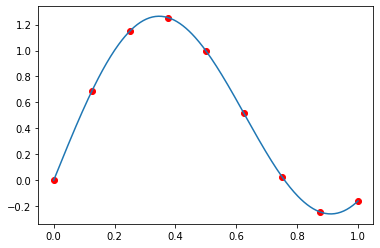

In [30]:
# Just plotting the function as it exists

def yf(x):
    x0 = x[:, 0]
    return np.sin(5 * x0) + .8 * x0

x = np.linspace(0, 1, 9)[:, None]
y = yf(x)
xx = np.linspace(0, 1, 300)[:, None]
yy = yf(xx)
plt.plot(x[:, 0], y, 'or')
plt.plot(xx[:, 0], yy);

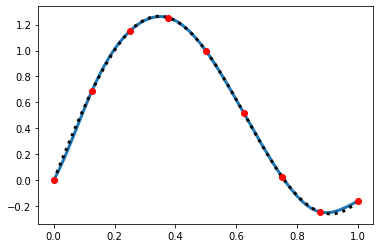

In [31]:
# For an arbitrary shape parameter, the fit to the data is pretty good

length_scale = .01
K_int = matern4(x, x, length_scale) + observation_noise * np.eye(len(x))
K_eval = matern4(xx, x, length_scale)

yp_mean = np.dot(K_eval, np.linalg.solve(K_int, y))
plt.plot(xx[:, 0], yp_mean, linewidth=3)

plt.plot(xx[:, 0], yy, ':k', linewidth=3)
plt.plot(x[:, 0], y, 'or');

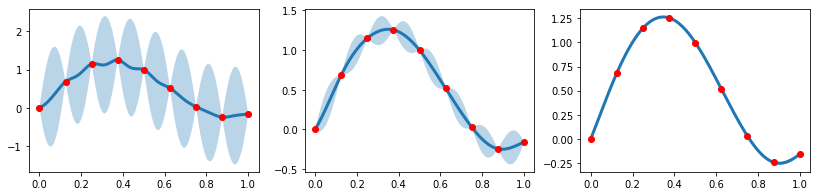

In [32]:
# We can consider several different shape parameters and see the impact both on the mean and variance of the predictions

fig, axes = plt.subplots(1, 3, figsize=(14, 3))
for length_scale, ax in zip((.001, .01, .1), axes):
    process_variance = 1.0
    K_int = matern4(x, x, length_scale) + observation_noise * np.eye(len(x))
    K_eval = matern4(xx, x, length_scale)

    yp_mean = np.dot(K_eval, np.linalg.solve(K_int, y))
    yp_var = process_variance * (1 - np.sum(K_eval.T * np.linalg.solve(K_int, K_eval.T), axis=0))
    yp_std = np.sqrt(yp_var)

    ax.plot(xx[:, 0], yp_mean, linewidth=3)
    ax.fill_between(xx[:, 0], yp_mean - 2 * yp_std, yp_mean + 2 * yp_std, alpha=.3)
    ax.plot(x[:, 0], y, 'or');

# Gaussian process: posterior draws

The results shown above are summary statistics of data on a pairwise independent basis.  If we, instead, wanted to consider posterior results that are jointly distributed, it's a more complicated computation.  What we have below is the same computation run two slightly different ways.  The bottom computation is more efficiently because it reuses the Cholesky factorization -- it's also more stable for the same reason (the computation is symmetric).

Nonetheless, the computation of the `K_eval_posterior` quantity is subject to [loss of precision](https://en.wikipedia.org/wiki/Catastrophic_cancellation).  To counteract that, we add a `posterior_fudge_factor` which helps make sure the necessary Cholesky computation is stably computed.  This could probably be considered something like "the minimum pointwise posterior variance".

With the notation I've introduced in the talk, we can write that predictions $h$, given the observed data, take the pointwise posterior distribution
$$
h(x)\sim \mathcal{N}\left(\kk(\xx)^T(\mK+\sigma^2\mI_N)^{-1}\yy, K(\xx, \xx) - \kk(\xx)^T(\mK+\sigma^2\mI_N)^{-1}\kk(\xx)\right)
$$
where $\sigma^2$ is the observation noise.  To consider the jointly distributed posterior covariance, we need some more notation that I don't feel like writing here (but is commputed below).

In [33]:
num_posterior_samples = 123
length_scale = .01
process_variance = 1.0
posterior_fudge_factor = 1e-5

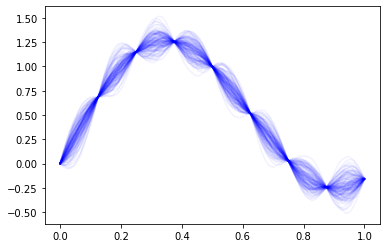

In [34]:
K_int = matern4(x, x, length_scale) + observation_noise * np.eye(len(x))
K_eval = matern4(xx, x, length_scale)
K_eval_prior = matern4(xx, xx, length_scale)

yp_mean = np.dot(K_eval, np.linalg.solve(K_int, y))

K_eval_posterior = K_eval_prior - np.dot(K_eval, np.linalg.solve(K_int, K_eval.T))
L_eval_posterior = np.linalg.cholesky(K_eval_posterior + posterior_fudge_factor * np.eye(len(K_eval_posterior)))
z_samples = np.random.normal(size=(len(yp_mean), num_posterior_samples))
posterior_draws = yp_mean[None, :] + np.dot(L_eval_posterior, z_samples).T

plt.plot(xx[:, 0], posterior_draws.T, color='b', alpha=.05);

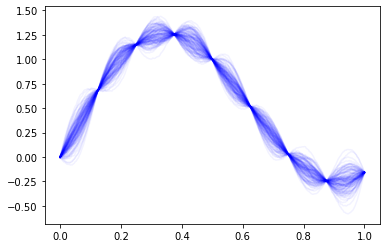

In [35]:
K_int = matern4(x, x, length_scale) + observation_noise * np.eye(len(x))
K_eval = matern4(xx, x, length_scale)
K_eval_prior = matern4(xx, xx, length_scale)

L_int = np.linalg.cholesky(K_int)

# Should probably actually use scipy.linalg.cho_factor, cho_solve, solve_triangular
yp_mean = np.dot(K_eval, np.linalg.solve(L_int.T, np.linalg.solve(L_int, y)))

V = np.linalg.solve(L_int, K_eval.T)
K_eval_posterior = K_eval_prior - np.dot(V.T, V)
L_eval_posterior = np.linalg.cholesky(K_eval_posterior + posterior_fudge_factor * np.eye(len(K_eval_posterior)))

z_samples = np.random.normal(size=(len(yp_mean), num_posterior_samples))
posterior_draws = yp_mean[None, :] + np.dot(L_eval_posterior, z_samples).T

plt.plot(xx[:, 0], posterior_draws.T, color='b', alpha=.05);

# Powering Bayesian optimization with Gaussian processes

Now that we can build statistical models of our data, we can use that to power our Bayesian optimization process.  To do so, we define an _acquisition function_ which encapsulates our desire to balance exploration versus exploitation.  We're going to phrase the problem as a minimization problem, but the math can work out equivalently if you have a maximization problem.

The improvement $I$ is defined as the gap between the previously observed best $Y^*$ and the predicted value $h$ at a location
$$
I(\xx) = (y^* - h(\xx))_+.
$$
Note that the improvement is only greater than 0 if the predicted outcome is lower than the previously observed best.  The GP model we have built is a probabilistic model, so we want to compute the expected value for the improvement (in reality, we could consider some other statistic than the mean if we wanted to).  Because the posterior distribution is Gaussian, the expected improvement actually takes a nice closed form (if you consider the error function closed form):
$$
EI(\xx) = \int_{-\infty}^\infty (y^* - h(\xx))_+ \; \text{d}\xx = \int_{-\infty}^{y^*} (y^* - h(\xx))\;\text{d}\xx = s(\xx)(\xi(\xx)\Phi(\xi(\xx))+\phi(\xi(\xx)))
$$
where
$$
\xi(\xx) = \frac{y^*-\mu(\xx)}{s(\xx)},
$$
$\mu$ and $s$ are the posterior mean and standard deviation, and $\Phi$ and $\phi$ are the standard normal CDF and PDF, respectively.  Additionally, the derivative of EI is easy to computed (though we will not use it here).  Note that, below, I'm using the posterior sampling rather than closed form to do the computation.

To find the highest expected improvement, we're just going to sample a bunch of points.  In reality, you should probably use a genetic algorithm (that's what I would be doing).  But in 1D it doesn't really matter.

I'm just going to sample a few points to get the ball rolling trying to optimize a function that's kinda interesting.

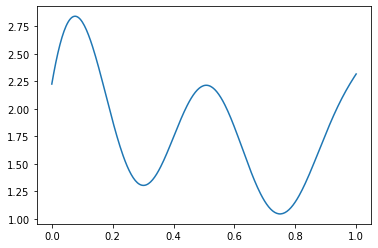

In [44]:
def yf(x):
    x0 = x[:, 0]
    return np.sin(6 * x0) + np.cos(13 * x0 + .1234) + np.sin(11 * x0 + .2345) + np.exp(x0)

xx = np.linspace(0, 1, 300)[:, None]
yy = yf(xx)
plt.plot(xx[:, 0], yy);

In [62]:
num_posterior_samples = 234
length_scale = .005
process_variance = 1.0
observation_noise = 1e-6
posterior_fudge_factor = 1e-4

In [63]:
# Make some helper functions -- in a real setting these would be encapsulated in objects
# These functions are just stealing constants from the global namespace -- should be passed in if we were doing this for real

def gp_posterior_draws(x, y, xx, num_posterior_samples=num_posterior_samples):
    K_int = matern4(x, x, length_scale) + observation_noise * np.eye(len(x))
    K_eval = matern4(xx, x, length_scale)
    K_eval_prior = matern4(xx, xx, length_scale)

    L_int = np.linalg.cholesky(K_int)
    yp_mean = np.dot(K_eval, np.linalg.solve(L_int.T, np.linalg.solve(L_int, y)))

    V = np.linalg.solve(L_int, K_eval.T)
    K_eval_posterior = K_eval_prior - np.dot(V.T, V) + posterior_fudge_factor * np.eye(len(K_eval_prior))
    L_eval_posterior = np.linalg.cholesky(K_eval_posterior)

    z_samples = np.random.normal(size=(len(yp_mean), num_posterior_samples))
    posterior_draws = yp_mean[None, :] + np.dot(L_eval_posterior, z_samples).T
    
    return posterior_draws

def expected_improvement(x, y, xx, num_posterior_samples=num_posterior_samples):
    y_star = np.min(y)
    draws = gp_posterior_draws(x, y, xx, num_posterior_samples)
    return np.mean(np.fmax(y_star - draws, 0), axis=0)

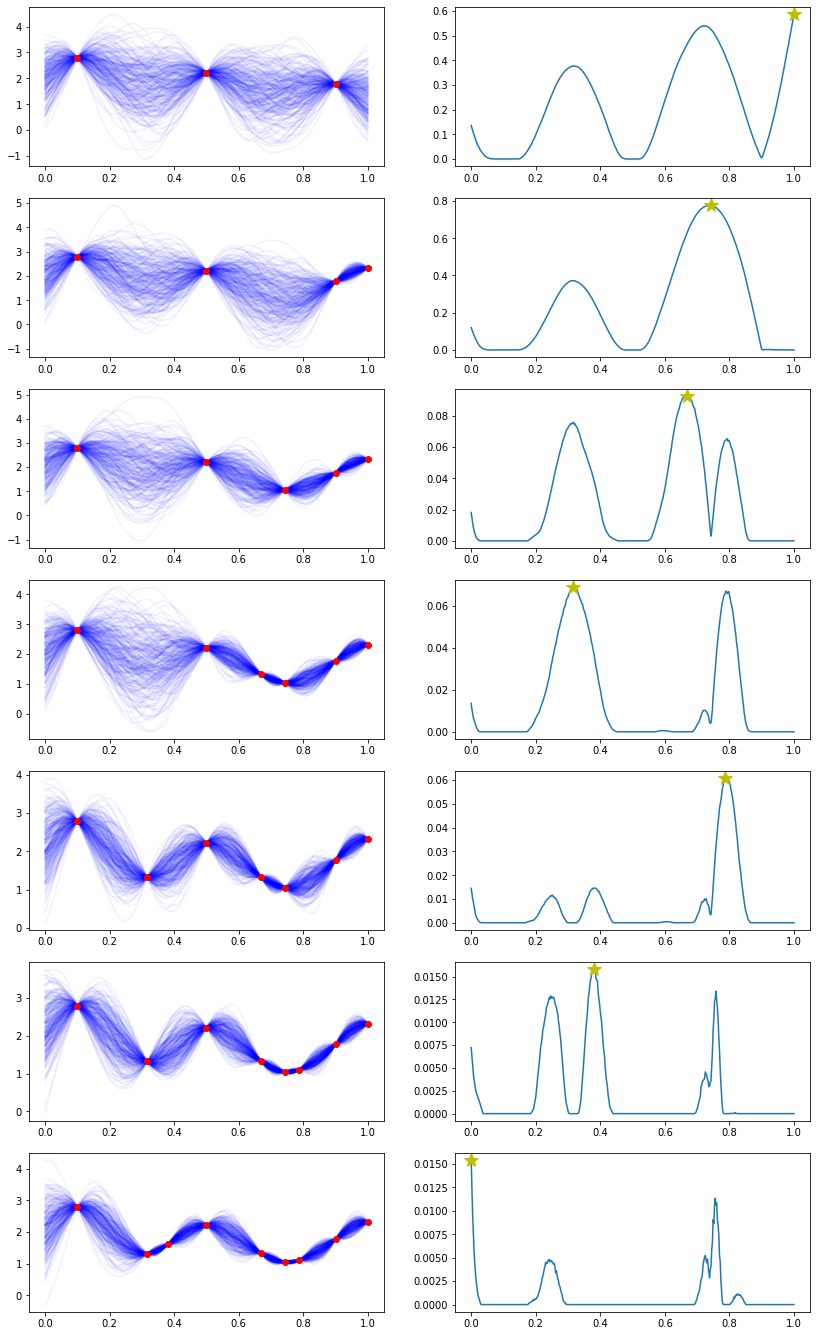

In [64]:
x = np.array([[.1, .5, .9]]).T
y = yf(x)
xx = np.linspace(0, 1, 456)[:, None]

fig, axes = plt.subplots(7, 2, figsize=(14, 24))

for row in range(len(axes)):
    gp_ax = axes[row, 0]
    ei_ax = axes[row, 1]
    
    draws = gp_posterior_draws(x, y, xx)
    gp_ax.plot(xx[:, 0], draws.T, color='b', alpha=.05)
    gp_ax.plot(x[:, 0], y, 'or')
    
    ei_vals = expected_improvement(x, y, xx)
    best_ei_index = np.argmax(ei_vals)
    x_next = xx[best_ei_index]
    ei_ax.plot(xx[:, 0], ei_vals)
    ei_ax.plot(x_next[0], ei_vals[best_ei_index], 'y*', markersize=14)
    
    x = np.concatenate((x, x_next[:, None]), axis=0)
    y = yf(x)